# Analyze 1 year Sentinel-1 TOPS stacks for Colombia Volcanoes

In [271]:
import numpy as np
import rasterio
import pandas as pd
import vmodels as vm
import os
from lxml import objectify
import glob

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker

plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['font.size'] = '24' #For Poster

%matplotlib inline

In [11]:
os.chdir('Galeras_TS/vrts')
#%qtconsole

In [4]:
def load_topsProcXML(path):
    with open(path) as f:
        xml = f.read()

    root = objectify.fromstring(xml)
    return df

# NOTE: appears topsProc.xml isn't proper xml, and also insn't produced in 201609 ISCE version
#XMLSyntaxError: Namespace prefix Geocoding on _ is not defined, line 86, column 21

In [5]:
def load_baselines(path):
    df = pd.read_csv(path)
    df['sceneDate'] =  pd.to_datetime(df.date,format='%Y%m%d')
    df['dt'] = df.sceneDate - df.sceneDate.iloc[0] 
    
    return df

In [6]:
from ast import literal_eval as make_tuple
def load_pairs(path, df):
    DF = pd.read_csv(path)
    for i,pair in enumerate(DF.pairs):
        #simplfy this by saving master slave columns
        indm,inds = make_tuple(pair)
        DF.ix[i,'masterInd'] = indm
        DF.ix[i,'masterDate'] = df.sceneDate.loc[indm]
        DF.ix[i,'slaveInd'] = inds
        DF.ix[i,'slaveDate'] = df.sceneDate.loc[inds]
    DF['masterInd'] = DF.masterInd.astype('i4')
    DF['slaveInd'] = DF.slaveInd.astype('i4')
    return DF

In [266]:
pGaleras = [-77.37, 1.22, 4276]

In [12]:
dfB = load_baselines('D142_2_baselines.csv')

In [13]:
dfP = load_pairs('pairs.csv', dfB)

In [254]:
# Some basic info about the set
print(dfB.dateStr.iloc[0], ' to ', dfB.dateStr.iloc[-1])
print(len(dfP), ' Interferograms')
print(len(dfB), ' Dates')

2015-05-07  to  2016-08-05
45  Interferograms
17  Dates


In [255]:
dfB.head()

fileName  \
0  S1A_IW_SLC__1SSV_20150507T105138_20150507T1052...   
1  S1A_IW_SLC__1SSV_20150531T105140_20150531T1052...   
2  S1A_IW_SLC__1SSV_20150624T105141_20150624T1052...   
3  S1A_IW_SLC__1SSV_20150718T105141_20150718T1052...   
4  S1A_IW_SLC__1SSV_20150811T105143_20150811T1052...   

                                            geometry  frameNumber  \
0  POLYGON ((-76.2966 -0.1545, -75.8272 2.0922, -...          586   
1  POLYGON ((-76.29600000000001 -0.1542, -75.8265...          587   
2  POLYGON ((-76.1708 0.4647, -75.83069999999999 ...          587   
3  POLYGON ((-76.16970000000001 0.4646, -75.8297 ...          587   
4  POLYGON ((-76.1703 0.4646, -75.8302 2.0943, -7...          587   

   baselinePerp     dateStr  sceneDate      dt      date  month  
0      0.000000  2015-05-07 2015-05-07  0 days  20150507      5  
1    -78.801621  2015-05-31 2015-05-31 24 days  20150531      5  
2    -18.222112  2015-06-24 2015-06-24 48 days  20150624      6  
3     25.552640  2015-07-18 2015-07-18 72 days  20150718      7  
4     29.139788  2015-08-11 2015-08-11 96 days  20150811      8

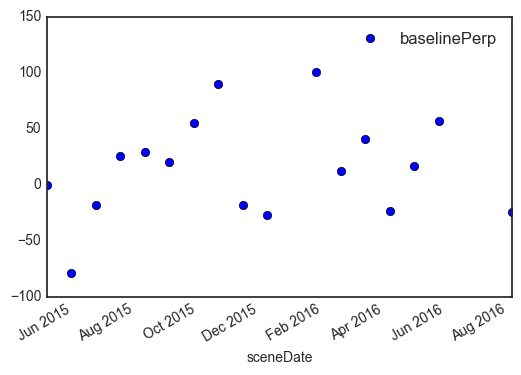

In [256]:
dfB.plot(x='sceneDate', y='baselinePerp', style='o')

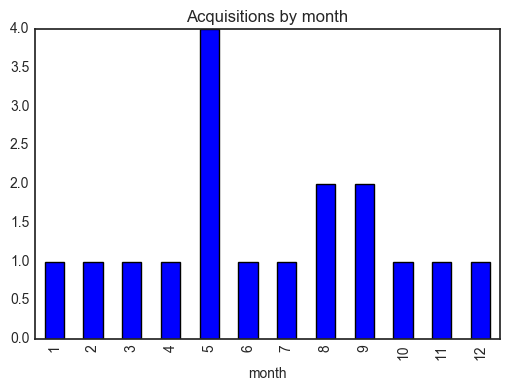

In [257]:
dfB['month'] = dfB.sceneDate.apply(lambda x: x.month)
gb = dfB.groupby('month')
gb.fileName.count().plot.bar() #show numner of acquisitions per month
plt.title('Acquisitions by month')

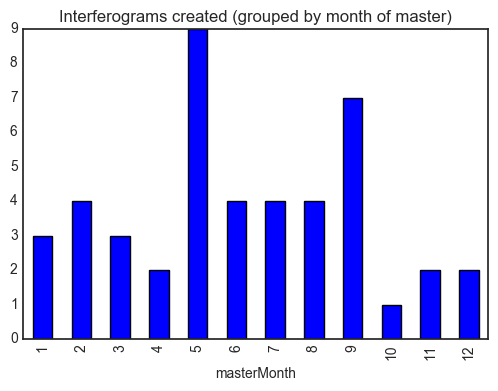

In [18]:
dfP['masterMonth'] = dfP.masterDate.apply(lambda x: x.month)
gb = dfP.groupby('masterMonth')
gb.pairs.count().plot.bar() #show numner of acquisitions per month
plt.title('Interferograms created (grouped by month of master)')

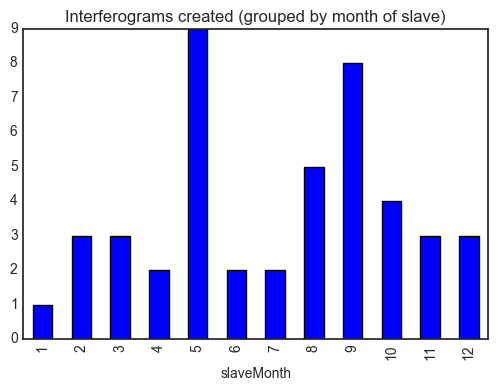

In [19]:
dfP['slaveMonth'] = dfP.slaveDate.apply(lambda x: x.month)
gb = dfP.groupby('slaveMonth')
gb.pairs.count().plot.bar() #show numner of acquisitions per month
plt.title('Interferograms created (grouped by month of slave)')

In [227]:
# Load a single interferogram
def load_ifg(pair):
    stackdir = 'Dropbox/InSAR_Results/Galeras_TS/vrts'
    #pair = 'int_20160525_20160805' #bad unw

    product = 'los.rdr.geo.8alks_8rlks.geo.vrt'
    path = os.path.join(os.environ['HOME'],stackdir,pair+'_'+product)
    data,extent,meta = vm.util.load_rasterio(path)
    data[data==0] = np.nan
    incd,head = data

    product = 'phsig.cor.geo.8alks_8rlks.geo.vrt'
    path = os.path.join(os.environ['HOME'],stackdir,pair+'_'+product)
    data,extent,meta = vm.util.load_rasterio(path)
    data[data==0] = np.nan
    cor = data[0]

    product = 'filt_topophase.unw.8alks_8rlks.geo.vrt'
    path = os.path.join(os.environ['HOME'],stackdir,pair+'_'+product)
    data,extent,meta = vm.util.load_rasterio(path)
    data[data==0] = np.nan
    amp,phs = data
    
    return incd,head,cor,phs

In [267]:
def plot_aux(pair):
    incd,head,cor,phs = load_ifg(pair)
    # a few simple plots
    # http://stackoverflow.com/questions/32633322/changing-aspect-ratio-of-subplots-in-matplotlib
    fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(11,6), subplot_kw=dict(adjustable='box-forced'))
    ax = axes[0]
    ax.set_title('incidence [deg] {:.1f}'.format(np.nanmean(incd)))
    im = ax.imshow(incd, extent=extent)
    plt.colorbar(im, ax=ax, shrink=0.5)

    ax = axes[1]
    ax.set_title('heading [deg], {:.1f}'.format(np.nanmean(head)))
    im = ax.imshow(head, extent=extent)
    plt.colorbar(im, ax=ax, shrink=0.5)

    ax = axes[2]
    ax.set_title('coherence [] {:.1f}'.format(np.nanmean(cor)))
    im = ax.imshow(cor, vmin=0, vmax=1, extent=extent)
    plt.colorbar(im, ax=ax, shrink=0.5)
    
    #Add a particular point
    for ax in axes:
        ax.plot(pGaleras[0], pGaleras[1], 'k^')

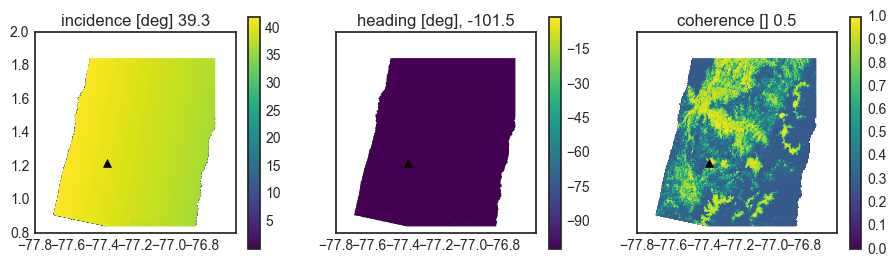

In [268]:
pair = 'int_20150718_20150811'
plot_aux(pair)

-4.92227


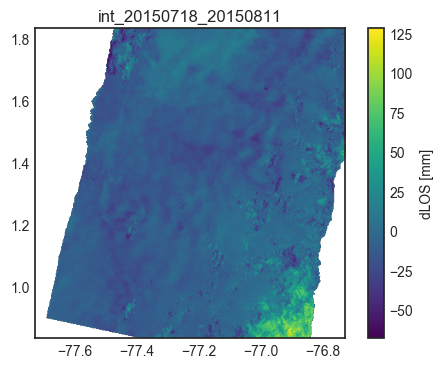

In [272]:
# Plot the phase and load elevations (dem.crop.geo?)
incd,head,cor,phs = load_ifg(pair)
mm = phs*55.46576/12.5663706  #For sentinel
plt.imshow(mm, extent=extent)
cb = plt.colorbar()
plt.title(pair)
cb.set_label('dLOS [mm]')
print(np.nanmean(mm))

DC-shift [mm]= -7.15066


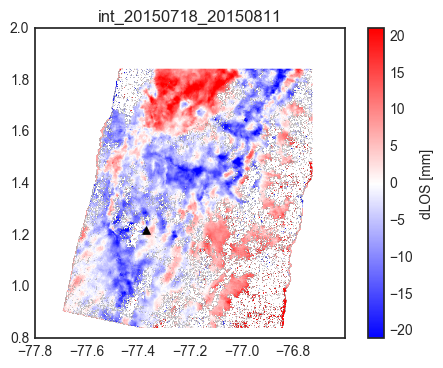

In [283]:
# Mask by coherence and plot with balanced colorbar
thresh = 0.3
mm_m = mm.copy()
mm_m[cor < thresh] = np.nan
mu = np.nanmean(mm_m)
sigma = np.nanstd(mm_m)
#norm = plt.cm.colors.Normalize(vmin=mu-2*sigma, vmax=mu+2*sigma) #otherwise edge effects dominate..
# NOTE: only creates balances color scale if symmetrical (no skewness in dynamic range)
# apply DC shift
print('DC-shift [mm]=', mu)
mm_m = mm_m - mu
norm = plt.cm.colors.Normalize(vmin=-2*sigma, vmax=+2*sigma) 

plt.imshow(mm_m, extent=extent, norm=norm, cmap='bwr')
plt.plot(pGaleras[0], pGaleras[1], 'k^')
cb = plt.colorbar()
plt.title(pair)
cb.set_label('dLOS [mm]')
#print(np.nanmean(mm_m))
plt.savefig('{}_los.pdf'.format(pair), bbox_inches='tight')

### Notes
* seems pretty clear that unrapping will be prone to errors, should geocode connected components from snaphu
* maybe better using coherence threshold < 0.3 to aid continuity (compare coherence <0.3 to 0.5)
    * with more pixels, you notice NE-SW streaking probably due to clouds (not accounted for in PyAPS)
    * could use MODIS cloud-maps for daytime acquisitions to add a cloud likelihood flag (eventually empirical correction)

(-105, -95)

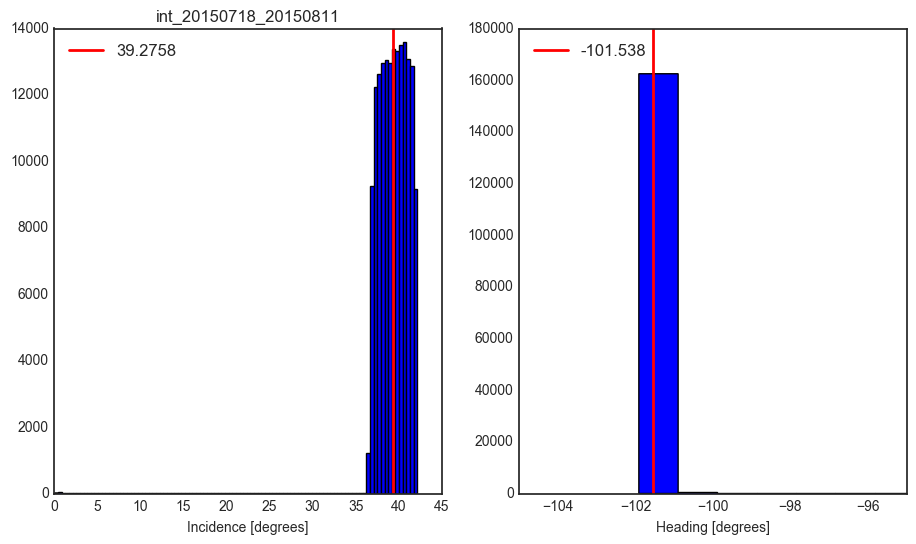

In [207]:
# Histograms too
fig, axes = plt.subplots(1,2,figsize=(11,6))

plt.sca(axes[0])
junk = plt.hist(incd[np.isfinite(incd)], bins=100)
plt.axvline(np.nanmean(incd),color='r',lw=2, label=np.nanmean(incd))
plt.title(pair)
plt.xlabel('Incidence [degrees]')
plt.legend(loc='upper left')
# NOTE: edge effects create some weird values, should probably mask any values < 35

plt.sca(axes[1])
junk = plt.hist(head[np.isfinite(head)], bins=100)
plt.axvline(np.nanmean(head),color='r',lw=2, label=np.nanmean(head))
plt.xlabel('Heading [degrees]')
plt.legend(loc='upper left')
plt.xlim(-105,-95)
# NOTE: edge effects create some weird values, should probably mask any weird values

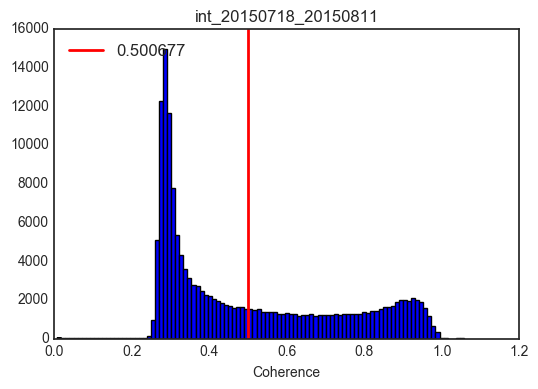

In [208]:
# Histograms too
junk = plt.hist(cor[np.isfinite(cor)], bins=100)
plt.axvline(np.nanmean(cor),color='r',lw=2, label=np.nanmean(cor))
plt.title(pair)
plt.xlabel('Coherence')
plt.legend(loc='upper left')
# NOTE: edge effects create some weird values, should probably mask any values < 35

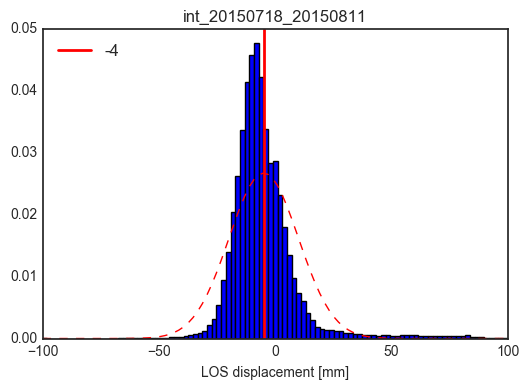

In [284]:
# Histograms too
#n, bins, patches = plt.hist(mm[np.isfinite(mm)], normed=True, bins=100)
n, bins, patches = plt.hist(mm[np.isfinite(mm)], normed=True, bins=np.linspace(-1e2,1e2,100))

mean = np.nanmean(mm)
std = np.nanstd(mm)

y = mlab.normpdf(bins, mean, std)
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.axvline(mean,color='r',lw=2, label=int(mean))
#plt.axvline(mean+std,color='r',lw=1, linestyle='dashed', label=int(std))
#plt.axvline(mean-std,color='r',lw=1, linestyle='dashed', label=int(std))
plt.title(pair)
plt.xlabel('LOS displacement [mm]')
plt.legend(loc='upper left')
# NOTE: edge effects create some weird values, should probably mask any values < 35
#plt.savefig('los_displacement_variance.pdf',bbox_inches='tight')
plt.savefig('{}_los_hist.pdf'.format(pair),bbox_inches='tight')

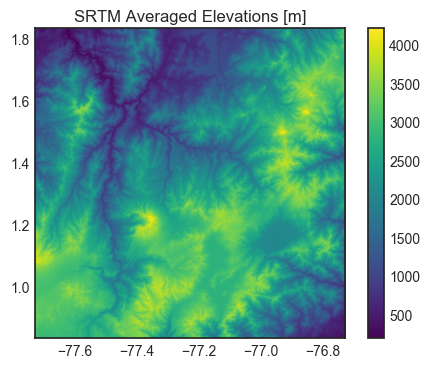

In [27]:
# Crop SRTM data to same grid as geocoded data
# http://gis.stackexchange.com/questions/125202/gdal-clipping-a-raster-with-another-raster
#gdaltindex clipper.shp int_20160314_20160501_filt_topophase.unw.8alks_8rlks.geo.vrt
#gdalwarp -ts 450 450 -cutline clipper.shp -crop_to_cutline /home/data/dems/srtmGL1/colombia/demLat_S04_N12_Lon_W081_W070.dem.wgs84.vrt dem.tif
product = 'dem.tif'
path = os.path.join(os.environ['HOME'],stackdir,product)
data,extent,meta = vm.util.load_rasterio(path)
elev = data[0]
plt.imshow(elev, extent=extent)
plt.title('SRTM Averaged Elevations [m]')
plt.colorbar()

In [334]:
def plot_dem_cor_los(pair, dem, cor, los, norm=True):
    #incd,head,cor,phs = load_ifg(pair)
    # a few simple plots
    # http://stackoverflow.com/questions/32633322/changing-aspect-ratio-of-subplots-in-matplotlib
    fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,6), subplot_kw=dict(adjustable='box-forced'))
    ax = axes[2]
    ax.set_title('Elevation')
    im = ax.imshow(dem, extent=extent)
    cb = plt.colorbar(im, ax=ax, shrink=0.4)
    cb.set_label('[m]')

    ax = axes[1]
    ax.set_title('Coherence')
    im = ax.imshow(cor, extent=extent)
    plt.colorbar(im, ax=ax, shrink=0.4)

    ax = axes[0]
    ax.set_title(pair)
    if norm:
        norm = plt.cm.colors.Normalize(vmin=-2*sigma, vmax=+2*sigma) 
    im = ax.imshow(los, extent=extent, norm=norm, cmap='bwr')
    cb = plt.colorbar(im, ax=ax, shrink=0.4)
    cb.set_label('dLOS [mm]')
    
    #Add a particular point
    for ax in axes:
        #plt.autoscale(False)
        ax.plot(pGaleras[0], pGaleras[1], 'k^', scalex=False, scaley=False) #mec='k',mfc='w', mew=2, 
        
    plt.savefig('{}_phs_cor_dem.pdf'.format(pair), bbox_inches='tight')

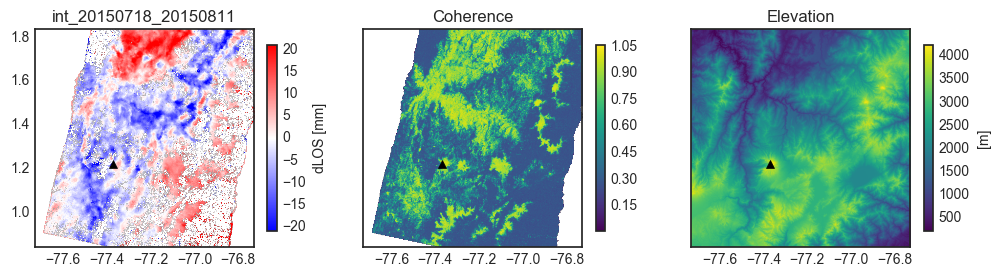

In [335]:
plot_dem_cor_los(pair, elev, cor, mm_m)

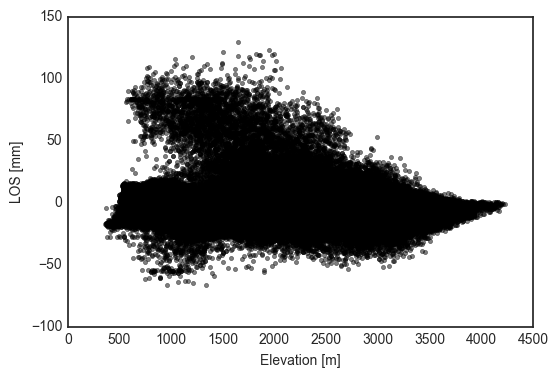

In [313]:
# A common diagnostic of atmospheric signal is if unwrapped phase is correlated with elevation
plt.plot(elev.flatten(),mm.flatten(),'k.',alpha=0.5)
plt.ylabel('LOS [mm]')
plt.xlabel('Elevation [m]')

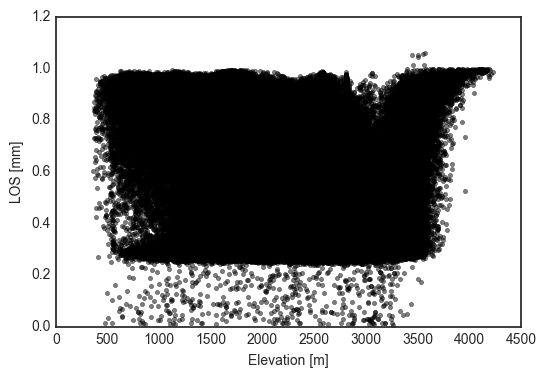

In [314]:
# In the andes, due to vegetation, maybe the coherence is correlated...
plt.plot(elev.flatten(),cor.flatten(),'k.',alpha=0.5)
plt.ylabel('LOS [mm]')
plt.xlabel('Elevation [m]')
# NOTE: there shouldn't be coherence values above 1, so probably edge effect. Odd floor at 0.3... Also, looks like Washington State flipped

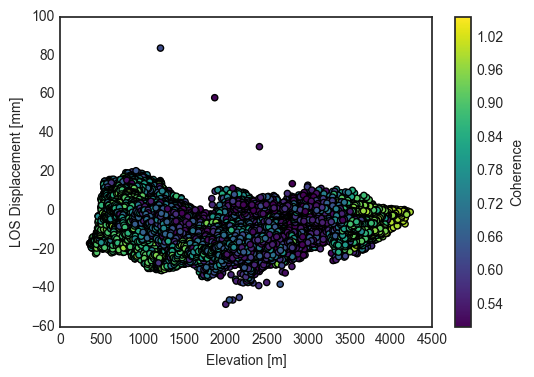

In [315]:
# Let's assume any phase values with coherence<0.5 are noise (pretty agressive)
ind = (cor>0.5)
#ind = (cor>0) #Huge difference!
# Or use a scatter plot and color by coherence
sc = plt.scatter(x=elev[ind].flatten(),y=mm[ind].flatten(),c=cor[ind].flatten())
plt.ylabel('LOS Displacement [mm]')
plt.xlabel('Elevation [m]')
cb = plt.colorbar(sc)
cb.set_label('Coherence')

Definitely more coherence in higher elevations, but also some higher coherence pixels at very low elevations.

In [316]:
# Summary of since interferogram
print('LOS mean [mm] = {:.1f}'.format(np.nanmean(mm)))
print('LOS std [mm] = {:.1f}'.format(np.nanstd(mm))) # 'root mean square deviation'
print('Coherence mean = {:.1f}'.format(np.nanmean(cor)))
print('% Pixels with coherence > 0.5 = {:.1f}'.format((cor>0.5).sum()*100/np.isfinite(cor).sum()))

LOS mean [mm] = -4.9
LOS std [mm] = 15.0
Coherence mean = 0.5
% Pixels with coherence > 0.5 = 40.1


In [317]:
# Add these values to pairs data frame for aggregate statistics
def load_data(master,slave):
    stackdir = 'Dropbox/InSAR_Results/Galeras_TS/vrts'
    #pair = 'int_20160525_20160805' #bad unw
    pair = 'int_{0}_{1}'.format(master.strftime('%Y%m%d'), slave.strftime('%Y%m%d'))
    
    product = 'phsig.cor.geo.8alks_8rlks.geo.vrt'
    path = os.path.join(os.environ['HOME'],stackdir,pair+'_'+product)
    #print(pair)
    data,extent,meta = vm.util.load_rasterio(path)
    data[data==0] = np.nan
    cor = data[0]

    product = 'filt_topophase.unw.8alks_8rlks.geo.vrt'
    path = os.path.join(os.environ['HOME'],stackdir,pair+'_'+product)
    data,extent,meta = vm.util.load_rasterio(path)
    data[data==0] = np.nan
    phs = data[1]
    mm = phs*55.46576/12.5663706  #For sentinel
    
    return cor,mm

In [387]:
def mask_coherence(array, cor, thresh=0.5):
    ''' e.g. assume LOS displacements greater than 10 meteres are artifacts, set to nan '''
    noise = (np.abs(cor) <= thresh)
    print('{} pixels with coherence <= {} set to nan'.format(noise.sum(),thresh))
    
    outliers = (np.abs(cor) > 1) #shouldn't be more than 1 / less than -1
    print('{} pixels with coherence values out of range'.format(outliers.sum(),thresh))
    nmasked = noise.sum() + outliers.sum()
    
    array[noise] = np.nan
    array[outliers] = np.nan
    
    return array,nmasked

In [386]:
def mask_outliers(array, thresh=10e3):
    ''' e.g. assume LOS displacements greater than 10 meteres are artifacts, set to nan '''
    outliers = (np.abs(array) >= thresh) #convert to mm
    nmasked = outliers.sum()
    print('{} pixels with LOS >= {} [mm] set to nan'.format(nmasked,thresh))
    array = np.where(outliers, np.nan, array)
    return array,nmasked

In [327]:
def add_stats(df, corMask=True, outlierMask=False, thresh=0.5):
    for i,row in df.iterrows():
        try:
            cor,mm = load_data(row.masterDate, row.slaveDate)
            df.ix[i,'corMean'] = np.nanmean(cor)
            df.ix[i,'corStd'] = np.nanstd(cor)
            df.ix[i,'corPercent'] = (cor>thresh).sum()*100 / np.isfinite(cor).sum()   
            
            if corMask:
                mm, nmasked = mask_coherence(mm, cor, thresh)
                cor[np.isnan(mm)] = np.nan
                df.ix[i,'corMask'] = nmasked
            if outlierMask:
                mm, outMask = mask_outliers(mm)
                cor[np.isnan(mm)] = np.nan
                df.ix[i,'outMask'] = nmasked

            df.ix[i,'losMedian'] =  np.nanmedian(mm)
            df.ix[i,'losMean'] =  np.nanmean(mm)
            df.ix[i,'losStd'] =  np.nanstd(mm)
            df.ix[i,'losMin'] =  np.nanmin(mm)
            df.ix[i,'losMax'] =  np.nanmax(mm)

        except:
            #raise
            print('Failed to load data')
    #return df

In [329]:
add_stats(dfP, outlierMask=True)

Failed to load data
Failed to load data
Failed to load data
Failed to load data
Failed to load data


In [322]:
# Quick way to flag wierd results - get aggregate mean and flag values 
#dfP.corMean.describe()
#dfP.losMean.describe()
#dfP.outMask.describe()

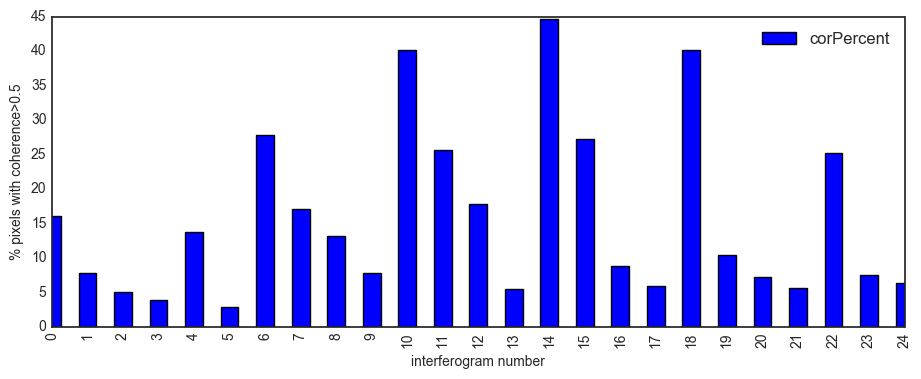

In [331]:
# Quickest way to estimate interferogram quality
dfP.plot.bar(y='corPercent', figsize=(11,4))
plt.ylabel('% pixels with coherence>0.5')
plt.xlabel('interferogram number')
plt.xlim(0,24)
plt.savefig('galeras_coherence_barchart.pdf', bbox_inches='tight')

In [356]:
# check that increasing coherence trend is seasonal, rather than tighter baselines in subgroup:
#gb = dfP.groupby('masterDate')
#gb.bperp.describe()
#gb.boxplot(column='bperp')

### Notes

* Nice trend of temporal decorrelation visible here for example (0-3) all have master date 2015-05-07|
    * 0 = 24
    * 1 = 47
    * 2 = 71
    * 3 = 95 days
    
* Check outliers 2 (low mean LOS), 17 & 42 (high variange) 

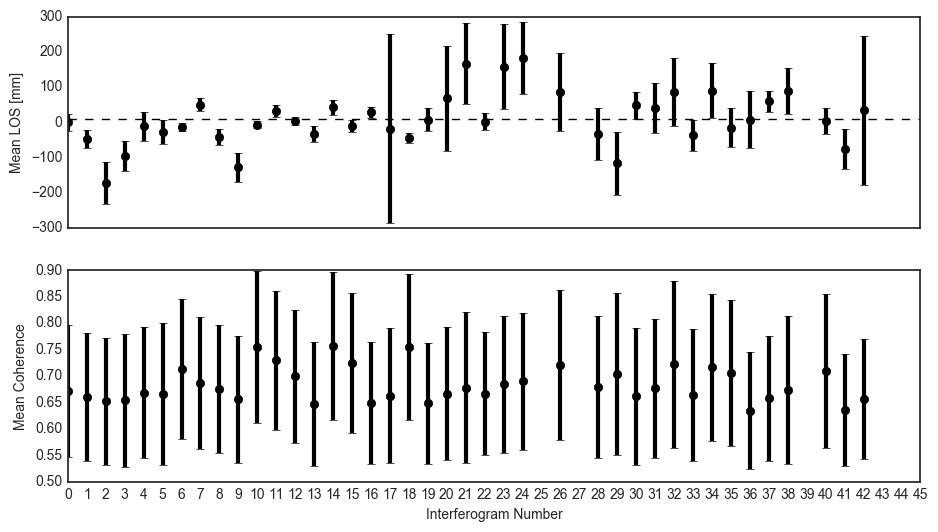

In [221]:
# simple bar plot summary
#http://stackoverflow.com/questions/33328774/box-plot-with-min-max-average-and-standard-deviation
fig,axes = plt.subplots(2,1, figsize=(11,6), sharex=True)
axes[0].errorbar(dfP.index.values, dfP.losMean, dfP.losStd, fmt='ok', lw=3)
#axes[0].errorbar(dfP.index.values, dfP.losMean, [dfP.losMean - dfP.losMin, dfP.losMax - dfP.losMean],
#             fmt='.k', ecolor='gray', lw=1)
axes[0].axhline(dfP.losMean.mean(), color='k', linestyle='--')
axes[0].set_ylabel('Mean LOS [mm]')

axes[1].errorbar(dfP.index.values, dfP.corMean, dfP.corStd, fmt='ok', lw=3)
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axes[1].set_xlabel('Interferogram Number')
axes[1].set_ylabel('Mean Coherence')


Couldn't load data
Couldn't load data
Couldn't load data
Couldn't load data
Couldn't load data


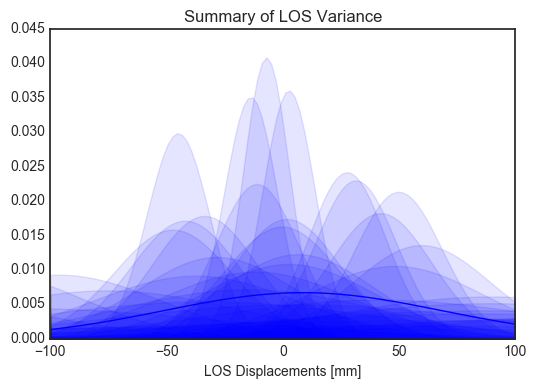

In [224]:
# Composite histogram of phase values
# http://matplotlib.org/1.2.1/examples/pylab_examples/histogram_demo.html
bins = np.linspace(-1e2,1e2,100)
plt.figure()
for i,row in dfP.iterrows():
    try:
        cor,mm = load_data(row.masterDate, row.slaveDate)
        mm, nmasked = mask_coherence(mm, cor, thresh)
        #cor[np.isnan(mm)] = np.nan
        mm, outMask = mask_outliers(mm)
        #cor[np.isnan(mm)] = np.nan
        #n, bins, patches = plt.hist(mm[np.isfinite(mm)], bins=50, alpha=0.1, color='b')
        mu = np.nanmean(mm)
        sigma = np.nanstd(mm)
        y = mlab.normpdf(bins, mu, sigma)
        plt.fill_between(bins, y, color='b',alpha=0.1)
    except:
        print("Couldn't load data")
        
y = mlab.normpdf(bins, dfP.losMean.mean(), dfP.losStd.mean())
plt.plot(bins, y, 'b-')
plt.xlabel('LOS Displacements [mm]')
plt.title('Summary of LOS Variance')
plt.xlim(-1e2,1e2)
plt.show()

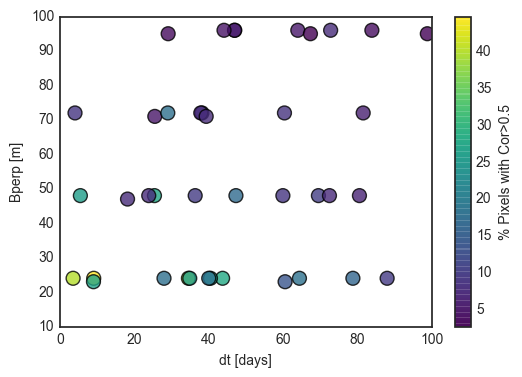

In [338]:
# Aggregate plot is temporal baseline versus perpendicular baseline colored by scatter
X = np.abs(dfP.bperp)
Y = dfP.dt
C = dfP.corPercent

sc = plt.scatter(x=X,y=Y,c=C,s=100,alpha=0.8)
plt.ylabel('Bperp [m]')
plt.xlabel('dt [days]')
plt.xlim(0,100)
cb = plt.colorbar(sc)
cb.set_label('% Pixels with Cor>0.5')

# Did I do something wrong, or are horizontal lines due to orbital pattern??
plt.savefig('bperp_vs_dt_galeras.pdf',bbox_inches='tight')

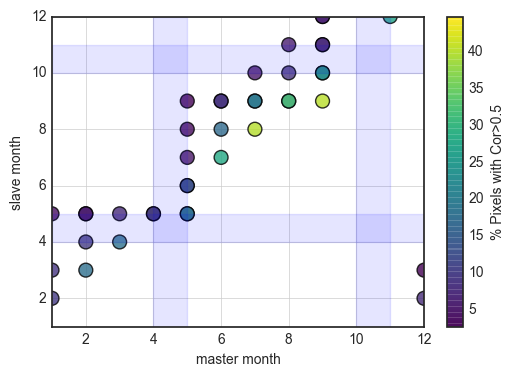

In [340]:
# Aggregate plot is temporal baseline versus perpendicular baseline colored by scatter
X = dfP.masterMonth
Y = dfP.slaveMonth
C = dfP.corPercent

sc = plt.scatter(x=X,y=Y,c=C,s=100,alpha=0.8)
plt.ylabel('slave month')
plt.xlabel('master month')
cb = plt.colorbar(sc)
cb.set_label('% Pixels with Cor>0.5')
plt.xlim(1,12)
plt.ylim(1,12)
plt.grid()

# highlight rainy seasons (April-May and Oct-Nov)
# NOTE: could show as parasite bar plot for either master or slave
plt.axvspan(4,5,color='b',alpha=0.1)
plt.axvspan(10,11,color='b',alpha=0.1)
plt.axhspan(4,5,color='b',alpha=0.1)
plt.axhspan(10,11,color='b',alpha=0.1) 
# Note, by chosen convention Master < SLave, and therefore, we have the diagonal 1:1 line
plt.savefig('master_vs_slave_month.pdf', bbox_inches='tight')

#### Ideas to expand...
 * Redo plot for pixels above a certain elevation (colombia tree line ~ )
 * Look for trends that have to do with season
 * Look for trends that have to do with large storm events...

In [248]:
def plot_ifg(mm,cor,norm=None):
    if norm:
        mu = np.nanmean(mm)
        sigma = np.nanstd(mm)
        normLOS = plt.cm.colors.Normalize(vmin=mu-2*sigma, vmax=mu+2*sigma)
        mu = np.nanmean(cor)
        sigma = np.nanstd(cor)
        normCOR = plt.cm.colors.Normalize(vmin=mu-2*sigma, vmax=mu+2*sigma)
        
    fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,10), 
                             subplot_kw=dict(adjustable='box-forced'))
    plt.sca(axes[0])
    plt.imshow(mm, norm=normLOS)
    cb = plt.colorbar(shrink=0.4)
    plt.title(pair)
    cb.set_label('LOS [mm]')

    plt.sca(axes[1])
    plt.imshow(cor, norm=normCOR)
    cb = plt.colorbar(shrink=0.4)
    cb.set_label('Coherence')

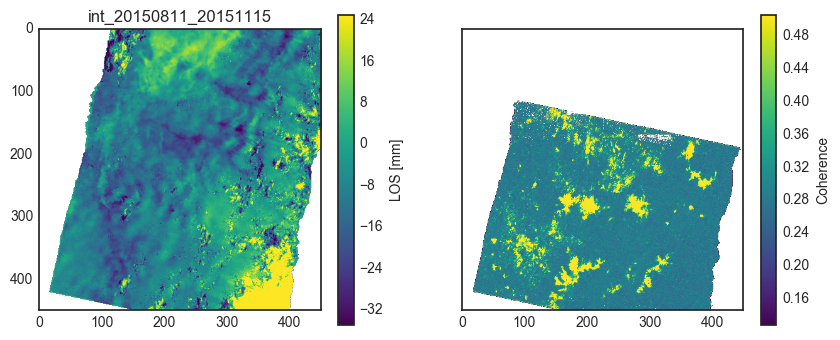

In [249]:
plot_ifg(mm,cor,norm=True)

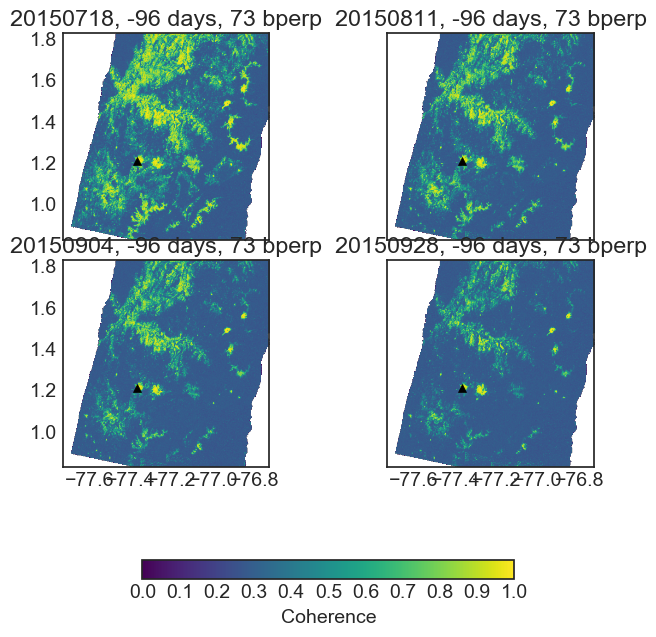

In [525]:
# 4x4 plot of best coherence at Galeras
fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,8), subplot_kw=dict(adjustable='box-forced'))

#for i,ifg in enumerate([14,15,16,17]):
for i,ifg in enumerate([6,7,8,9]):
    master = dfP.masterDate[ifg]
    slave = dfP.slaveDate[ifg]
    pair = 'int_{0}_{1}'.format(master.strftime('%Y%m%d'), slave.strftime('%Y%m%d'))
    cor,mm = load_data(master, slave)
    ax = axes.flat[i]
    ax.set_title('{}, {} days, {:.0f} bperp'.format(slave.strftime('%Y%m%d'), dt.days, bperp))
    im = ax.imshow(cor, extent=extent, vmin=0,vmax=1)
    ax.plot(pGaleras[0], pGaleras[1], 'k^', scalex=False, scaley=False)
    #plt.colorbar(im, ax=ax, shrink=0.4)

#plt.tight_layout() #too agressive
plt.subplots_adjust(hspace=0.1, wspace=0.1)
#cb = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, orientation='horizontal')
#cb.set_label('Coherence')
#plt.savefig('{}_coherence_panel.pdf'.format(master.strftime('%Y%m%d')), bbox_inches='tight')


0 pixels with LOS >= 10000.0 [mm] set to nan
59061 pixels with coherence <= 0.3 set to nan
0 pixels with coherence values out of range
nmasked 59061
0 pixels with LOS >= 10000.0 [mm] set to nan
80010 pixels with coherence <= 0.3 set to nan
0 pixels with coherence values out of range
nmasked 80010
0 pixels with LOS >= 10000.0 [mm] set to nan
89591 pixels with coherence <= 0.3 set to nan
0 pixels with coherence values out of range
nmasked 89591
0 pixels with LOS >= 10000.0 [mm] set to nan
102342 pixels with coherence <= 0.3 set to nan
0 pixels with coherence values out of range
nmasked 102342


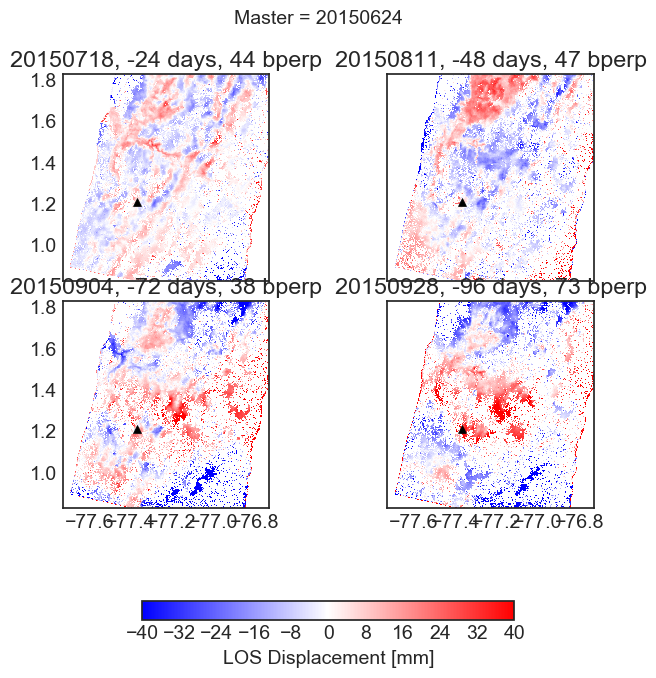

In [524]:
corthresh = 0.3
sigma = -20
sigma = 20
norm = plt.cm.colors.Normalize(vmin=-2*sigma, vmax=+2*sigma) 

fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,8), subplot_kw=dict(adjustable='box-forced'))

#for i,ifg in enumerate([14,15,16,17]):
for i,ifg in enumerate([6,7,8,9]):
    master = dfP.masterDate[ifg]
    slave = dfP.slaveDate[ifg]
    bperp = dfP.bperp[ifg]
    dt = master - slave
    pair = 'int_{0}_{1}'.format(master.strftime('%Y%m%d'), slave.strftime('%Y%m%d'))
    cor,mm = load_data(master, slave)
    mm,nmasked = mask_outliers(mm)
    mm,nmasked = mask_coherence(mm,cor,0.3)
    print('nmasked', nmasked)
    #dcshift = np.nanmean(mm)
    #print('DC shift', dcshift)
    #mm = mm - dcshift
    ramp = calc_ramp(mm)
    mm = mm - ramp
    
    ax = axes.flat[i]
    ax.set_title('{}, {} days, {:.0f} bperp'.format(slave.strftime('%Y%m%d'), dt.days, bperp))
    
    im = ax.imshow(mm, extent=extent, cmap='bwr', norm=norm, interpolation='none')
    ax.plot(pGaleras[0], pGaleras[1], 'k^', scalex=False, scaley=False)
#plt.colorbar(im, ax=ax, shrink=0.4)

#plt.tight_layout() #too agressive
plt.suptitle('Master = {}'.format(master.strftime('%Y%m%d'),fontsize=20))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
cb = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, orientation='horizontal')
cb.set_label('LOS Displacement [mm]')
plt.savefig('{}_unwrapped_phase_panel_deramp.pdf'.format(master.strftime('%Y%m%d')), bbox_inches='tight')

In [474]:
def world2rc(x,y,affine, inverse=False):
    '''
    World coordinates (lon,lat) to image (row,col) center pixel coordinates
    '''
    #T0 = src.meta['affine']
    T0 = affine
    T1 = T0 * rasterio.Affine.translation(0.5, 0.5)
    rc2xy = lambda r, c: (c, r) * T1
    # can probable simpligy,,, also int() acts like floor()
    xy2rc = lambda x, y: [int(i) for i in [x, y] * ~T1][::-1]

    if inverse:
        return rc2xy(y,x)
    else:
        return xy2rc(x,y)

In [508]:
# simple stack
def calc_ramp(array):
    ''' calculate best-fitting bilinear ramp across array '''
    X,Y = np.indices(array.shape) 
    x = X.reshape((-1,1))
    y = Y.reshape((-1,1))

    phs = np.ma.masked_invalid(array)
    d = phs.reshape((-1,1))
    g = ~d.mask
    dgood = d[g].reshape((-1,1))
    
    G = np.concatenate([x, y, x*y, np.ones_like(x)], axis=1)
    Ggood = np.vstack([x[g], y[g], x[g]*y[g], np.ones_like(x[g])]).T  
    m,resid,rank,s = np.linalg.lstsq(Ggood,dgood)
    
    ramp = np.dot(G,m)
    ramp = ramp.reshape(phs.shape)
    
    return ramp   

0 pixels with LOS >= 10000.0 [mm] set to nan
59061 pixels with coherence <= 0.3 set to nan
0 pixels with coherence values out of range
nmasked 59061
0 pixels with LOS >= 10000.0 [mm] set to nan
80010 pixels with coherence <= 0.3 set to nan
0 pixels with coherence values out of range
nmasked 80010
0 pixels with LOS >= 10000.0 [mm] set to nan
89591 pixels with coherence <= 0.3 set to nan
0 pixels with coherence values out of range
nmasked 89591
0 pixels with LOS >= 10000.0 [mm] set to nan
102342 pixels with coherence <= 0.3 set to nan
0 pixels with coherence values out of range
nmasked 102342


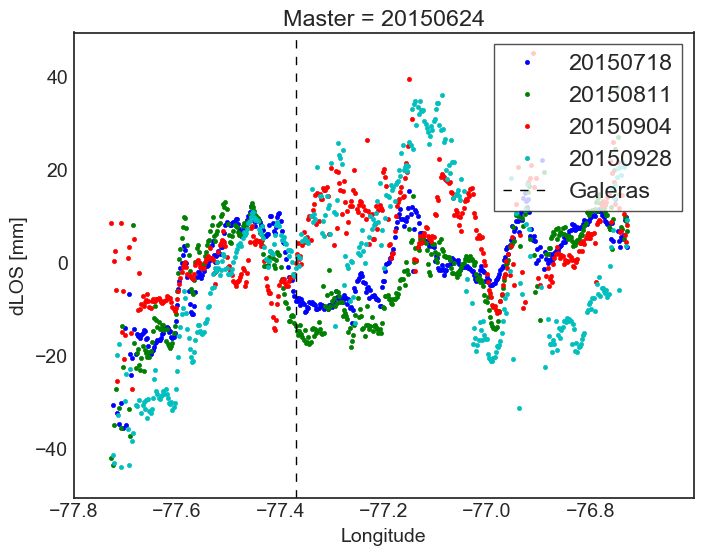

In [515]:
# EW Profiles through target volcano
x,y = world2rc(pGaleras[0], pGaleras[1], meta['affine'])
lons = np.linspace(extent[0],extent[1],mm.shape[0])#could also use meta dictionary...
corthresh = 0.3
sigma = -50
sigma = 50
#fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,8), subplot_kw=dict(adjustable='box-forced'))
plt.figure(figsize=(8,6))

#for i,ifg in enumerate([14,15,16,17]):
for i,ifg in enumerate([6,7,8,9]):
    master = dfP.masterDate[ifg]
    slave = dfP.slaveDate[ifg]
    bperp = dfP.bperp[ifg]
    dt = master - slave
    pair = 'int_{0}_{1}'.format(master.strftime('%Y%m%d'), slave.strftime('%Y%m%d'))
    cor,mm = load_data(master, slave)
    mm,nmasked = mask_outliers(mm)
    mm,nmasked = mask_coherence(mm,cor,0.3)
    print('nmasked', nmasked)
    
    #dcshift = np.nanmean(mm)
    #print('DC shift', dcshift)
    #mm = mm - dcshift
    # Ramp
    ramp = calc_ramp(mm)
    mm = mm - ramp
    
    #plt.plot(lons, mm[:,y], marker='.') #single line of pixels
    mu = np.nanmean(mm[:,y-5:y+5], axis=1)
    sigma = np.nanstd(mm[:,y-5:y+5], axis=1)
    plt.plot(lons, mu, marker='.', linestyle='none', label=slave.strftime('%Y%m%d'))
    #im = ax.imshow(mm, extent=extent, cmap='bwr', norm=norm, interpolation='none')

plt.axvline(pGaleras[0], color='k', linestyle='dashed', label='Galeras')
plt.xlabel('Longitude')
plt.ylabel('dLOS [mm]')
plt.title('Master = '+ master.strftime('%Y%m%d'))
plt.legend(loc='upper right', frameon=True, framealpha=0.8)
plt.ylim(-50,50)
plt.savefig('{}_bilinear_profiles_cor3.pdf'.format(master.strftime('%Y%m%d')), bbox_inches='tight')
#plt.savefig('{}_DCshift_profiles.pdf'.format(master.strftime('%Y%m%d')), bbox_inches='tight')
#plt.savefig('{}_noDCshift_profiles.pdf'.format(master.strftime('%Y%m%d')), bbox_inches='tight')

0 pixels with LOS >= 10000.0 [mm] set to nan
0 pixels with coherence <= 0.0 set to nan
0 pixels with coherence values out of range
nmasked 0
DC shift -20.5418
0 pixels with LOS >= 10000.0 [mm] set to nan
0 pixels with coherence <= 0.0 set to nan
0 pixels with coherence values out of range
nmasked 0
DC shift 47.3886
0 pixels with LOS >= 10000.0 [mm] set to nan
0 pixels with coherence <= 0.0 set to nan
0 pixels with coherence values out of range
nmasked 0
DC shift -56.9909
0 pixels with LOS >= 10000.0 [mm] set to nan
0 pixels with coherence <= 0.0 set to nan
0 pixels with coherence values out of range
nmasked 0
DC shift -152.53


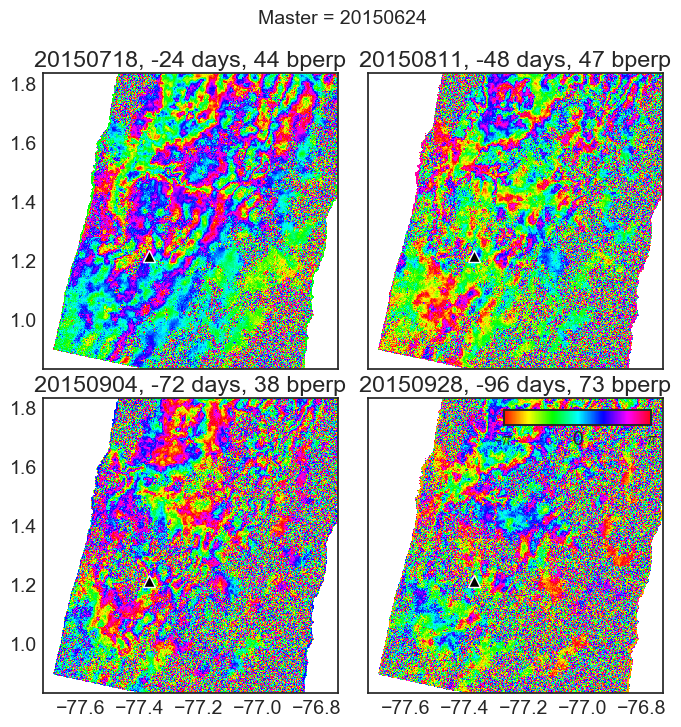

In [469]:
plt.rcParams['font.size'] = 14
wavelength = 55.46576
corthresh = 0.0
sigma = -50
sigma = 50
norm = plt.cm.colors.Normalize(vmin=-2*sigma, vmax=+2*sigma) 
fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,8), subplot_kw=dict(adjustable='box-forced'))
#for i,ifg in enumerate([14,15,16,17]):
for i,ifg in enumerate([6,7,8,9]):
    master = dfP.masterDate[ifg]
    slave = dfP.slaveDate[ifg]
    bperp = dfP.bperp[ifg]
    dt = master - slave
    pair = 'int_{0}_{1}'.format(master.strftime('%Y%m%d'), slave.strftime('%Y%m%d'))
    cor,mm = load_data(master, slave)
    mm,nmasked = mask_outliers(mm)
    mm,nmasked = mask_coherence(mm,cor,corthresh)
    print('nmasked', nmasked)
    dcshift = np.nanmean(mm)
    print('DC shift', dcshift)
    mm = mm - dcshift
    ax = axes.flat[i]
    ax.set_title('{}, {} days, {:.0f} bperp'.format(slave.strftime('%Y%m%d'), dt.days, bperp))
    
    # Structure is beetter visualized with wrapped colorbar (a la MDX)
    #los_wrapped = np.remainder(mm - np.nanmin(mm), wavelength/2.0) / (wavelength/2.0) #works best for synthetic data
    los_wrapped = np.remainder(mm - -100, wavelength/2.0) / (wavelength/2.0) 
    im = ax.imshow(los_wrapped, extent=extent, cmap='hsv', vmin=0, vmax=1, interpolation='none')
    
    #im = ax.imshow(mm, extent=extent, cmap='bwr', norm=norm, interpolation='none')
    ax.plot(pGaleras[0], pGaleras[1], 'k^', ms=8, mec='w', mew=1, scalex=False, scaley=False)
    
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax, width="50%", height="5%", loc=1) #upper right internal corner

cb = plt.colorbar(im, ax=ax, cax=axins, orientation='horizontal', ticks=[0,0.5,1])
cb.ax.set_xticklabels([r'-$\pi$','0', r'$\pi$'])
#cb.ax.set_frame_on(True)
#cb.ax.set_axis_bgcolor('white') #not working... could place outside of axes:
#http://matplotlib.org/examples/axes_grid/demo_colorbar_with_inset_locator.html
# OR back labels bold and white http://stackoverflow.com/questions/14477696/customizing-colorbar-border-color-on-matplotlib

#plt.colorbar(im, ax=ax, shrink=0.4)
#plt.tight_layout() #too agressive
plt.suptitle('Master = {}'.format(master.strftime('%Y%m%d'), fontsize=20))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.savefig('Temporal_Decorrelation_{}.pdf'.format(master.strftime('%Y%m%d')), bbox_inches='tight')
#cb = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, orientation='horizontal')

In [427]:
plt.rcParams['font.size']
%qtconsole

In [470]:
corthresh = 0.3
mmthresh = 1e3 #don't expect deformation exceding X meters in any single interferogram
disp = np.zeros_like(mm)
time = np.zeros_like(mm)
ramp = np.zeros_like(mm)

for i,row in dfP.iterrows():
    master = row.masterDate
    slave = row.slaveDate
    bperp = row.bperp
    dt = master - slave    
    dt_year = np.abs(dt.days / 365.25)   
    
    # Load data
    try:
        cor,mm = load_data(master, slave)
        mm,nmasked = mask_outliers(mm, mmthresh)
        mm,nmasked = mask_coherence(mm,cor,corthresh)

        # Normalize / Remove Ramp
        #ramp = calc_ramp(phs) 
        ramp = np.nanmean(mm) #dcshift
        print(ramp, 'dcshift')
        mm = mm - ramp

        masked = np.isnan(mm)
        time[~masked] += dt_year 
        disp[~masked] += phs[~masked]  

        ramp +=ramp #keep track of 'average ramp' - GIant Does network solution for this inversion...
    except:
        print('Trouble loading...', master, slave)

    
outofbounds = (time==0)
time[outofbounds] = np.nan
disp[outofbounds] = np.nan #not sure why any of those out of bounds values would be ok?
stack = disp / time # average velocity

#np.save('stack', stack)
#np.savez('stack_results', stack=stack,time=time,disp=disp,extent=extent)

0 pixels with LOS >= 1000.0 [mm] set to nan
72606 pixels with coherence <= 0.3 set to nan
0 pixels with coherence values out of range
-0.839303 dcshift
7 pixels with LOS >= 1000.0 [mm] set to nan
96722 pixels with coherence <= 0.3 set to nan
7 pixels with coherence values out of range
-48.146 dcshift
10 pixels with LOS >= 1000.0 [mm] set to nan
107432 pixels with coherence <= 0.3 set to nan
59 pixels with coherence values out of range
-184.308 dcshift
0 pixels with LOS >= 1000.0 [mm] set to nan
110973 pixels with coherence <= 0.3 set to nan
1 pixels with coherence values out of range
-102.408 dcshift
0 pixels with LOS >= 1000.0 [mm] set to nan
79500 pixels with coherence <= 0.3 set to nan
0 pixels with coherence values out of range
-3.66871 dcshift
0 pixels with LOS >= 1000.0 [mm] set to nan
118880 pixels with coherence <= 0.3 set to nan
1 pixels with coherence values out of range
-33.6883 dcshift
0 pixels with LOS >= 1000.0 [mm] set to nan
59061 pixels with coherence <= 0.3 set to nan

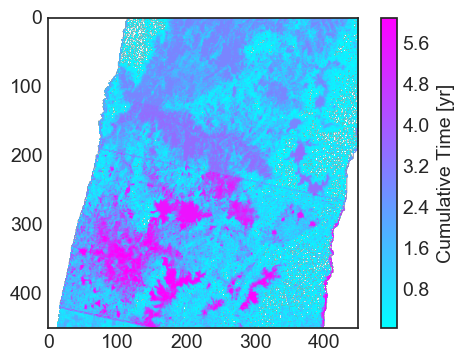

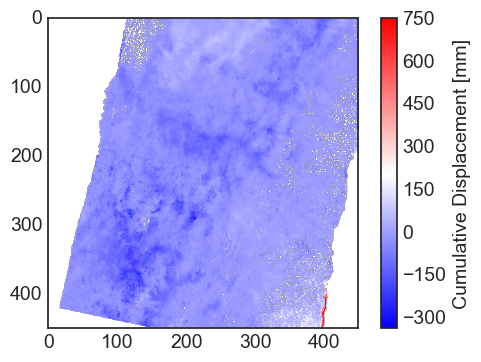

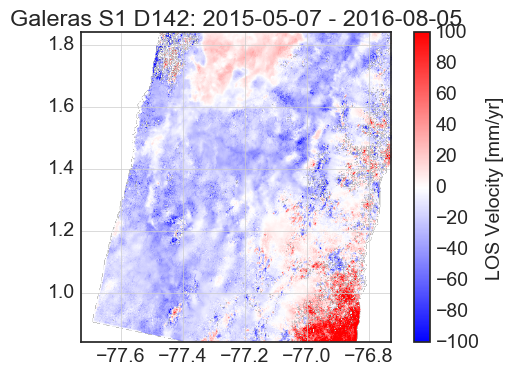

In [473]:
plt.figure()
plt.imshow(time, cmap=plt.cm.cool)
cb = plt.colorbar()
cb.set_label('Cumulative Time [yr]')

plt.figure()
plt.imshow(disp, cmap=plt.cm.bwr) # Better to use bwr b/c should be centered on zero.
cb = plt.colorbar()
cb.set_label('Cumulative Displacement [mm]')

# Use extent and plot lat lon location of def center and lastarria
#stack = np.load('stack.npy') #doesn't quite work... need to save extent too!

plt.figure() 
plt.imshow(stack, extent=extent, cmap=plt.cm.bwr) 

cb = plt.colorbar()
cb.set_label('LOS Velocity [mm/yr]')
plt.title('Galeras S1 D142: {} - {}'.format(dfB.dateStr.iloc[0], dfB.dateStr.iloc[-1]))
plt.grid(True)
plt.legend(loc='lower right',numpoints=1)
#need to manually set limits or do edge masking
plt.clim(-100,100)

plt.show()

#### NOTE: can experiment with corthresh and compare to GIAnT

In [428]:
# Save Pairs dataframe with statistics to prevent calculating later
dfP.to_csv('D142_Galeras_Stats.csv')

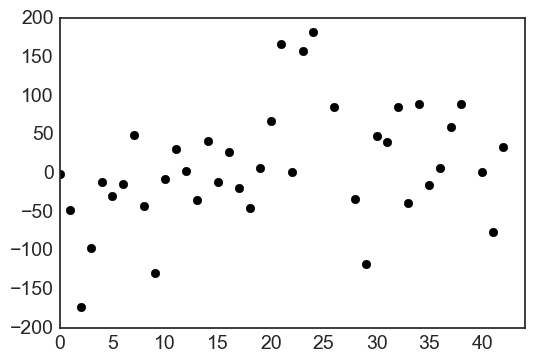

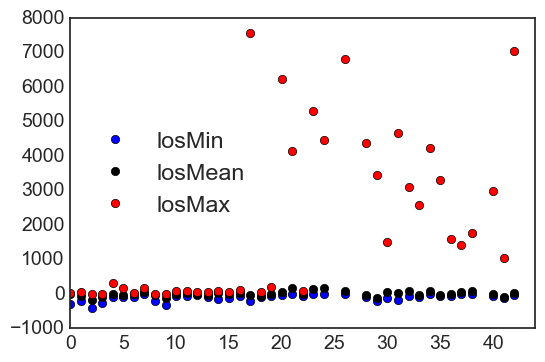

In [459]:
dfP.losMean.plot(style='ko')
dfP.plot(y=['losMin','losMean','losMax'], style=['bo','ko','ro'])

## Not sure why change in data quality after #15

In [507]:
%qtconsole